## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [1]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files.

In [2]:
# TODO: 1. Load images from folder into a list.
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load all images from a dataset directory (train/val/test) into memory.
    Make sure:
        1. Load training and validation set images and labels in the correct order.
        2. Load testing set images in filename order (e.g., 0.jpg, 1.jpg, ...).

    Parameters:
    -----------
    set_dir : str
        Path to the directory containing either:
        - Class subdirectories (for train/val sets)
        - Direct image files (for test set)

    Returns:
    --------
    Tuple[List[np.ndarray], List[str]]
        images: List of BGR images (HWC format, uint8 dtype)
        labels: List of string labels (empty for test set)

    Example:
    --------
    >>> images_train, labels_train = image_loader("../dataset_split/train")
    >>> images_test, _ = image_loader("../dataset_split/test")
    """
    images, labels = [], []
    
    # List all valid items (exclude hidden files)
    all_items = [f for f in os.listdir(set_dir) if not f.startswith(".")]
    all_items.sort()
    
    # Check whether there are subdirectories
    sub_dirs = [d for d in all_items if os.path.isdir(os.path.join(set_dir, d))]
    
    if sub_dirs:  # ➜ Train / Val mode
        for class_name in sub_dirs:
            class_dir = os.path.join(set_dir, class_name)
            for img_name in sorted(os.listdir(class_dir)):
                if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                    continue
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
                else:
                    print(f"[Warn] Failed to load {img_path}")
    else:  # ➜ Test mode (flat image files)
        img_files = [f for f in all_items if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        # Sort numerically if filenames are digits (e.g. 0.jpg, 1.jpg ...), otherwise alphabetically
        try:
            img_files.sort(key=lambda x: int(os.path.splitext(x)[0]))
        except ValueError:
            img_files.sort()
        for img_name in img_files:
            img_path = os.path.join(set_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
            else:
                print(f"[Warn] Failed to load {img_path}")
    
    return images, labels


In [3]:
# TODO: 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    """
    Resize images with the shortest edge to target_size and perform center cropping to square dimensions.

    Args:
        images: List of input images in BGR format (OpenCV default) with shape (H, W, C)
        target_size: Desired output size (both width and height after cropping). Default 224.

    Returns:
        Stacked numpy array of processed images with shape (N, target_size, target_size, 3)
        where N is the number of input images

    Raises:
        ValueError: If input images have inconsistent channels or invalid dimensions

    Notes:
        - Preserves original aspect ratio during resizing
        - Performs center cropping to exact square dimensions
        - Maintains uint8 dtype unless conversion forces float32

    Example:
        >>> imgs = [cv2.imread('test.jpg')]  # List of BGR images
        >>> processed = img_resize(imgs)
        >>> processed.shape  # (1, 224, 224, 3)
    """
    if not images:
        return np.array([])

    #  Verify the first image has at least 3 dimensions (H, W, C).
    first_shape = images[0].shape
    if len(first_shape) != 3:
        raise ValueError("Each input image must have shape (H, W, C).")

    expected_channels = first_shape[2]           # usually 3 for colour images

    for idx, img in enumerate(images):
        # Dimension check
        if len(img.shape) != 3:
            raise ValueError(
                f"Image at index {idx} has invalid shape {img.shape}; "
                "expected (H, W, C)."
            )
        # Channel-count check
        if img.shape[2] != expected_channels:
            raise ValueError(
                f"Inconsistent channels: image 0 has {expected_channels}, "
                f"image {idx} has {img.shape[2]}."
            )
    
    processed_images = []
    for img in images:
        h, w = img.shape[:2]
        # Scale so that the shorter edge == target_size
        scale = target_size / min(h, w)
        new_w, new_h = int(round(w * scale)), int(round(h * scale))
        img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Centre-crop to target_size × target_size
        start_x = (new_w - target_size) // 2
        start_y = (new_h - target_size) // 2
        img_cropped = img_resized[start_y:start_y + target_size,
                                  start_x:start_x + target_size]
        processed_images.append(img_cropped)

    return np.stack(processed_images)

In [4]:
# Load images

images_train, labels_train = image_loader(r"D:\Phase-2-Data-Science-FengJiang-main\3. Deep Learning Project\dataset_split\train")
images_val, labels_val = image_loader(r"D:\Phase-2-Data-Science-FengJiang-main\3. Deep Learning Project\dataset_split\val")
images_test, _ = image_loader(r"D:\Phase-2-Data-Science-FengJiang-main\3. Deep Learning Project\dataset_split\test")

print(f"# Train images: {len(images_train)}")
print(f"# Train labels: {len(labels_train)}")
print(f"Unique labels: {set(labels_train)}")

# Train images: 7800
# Train labels: 7800
Unique labels: {'rugby', 'sunglasses', 'tiger_cat', 'african_elephant', 'convertible_car', 'goldfish', 'golden_retriever', 'parachute', 'airliner', 'banana'}


In [5]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [6]:
from torchvision import transforms as T

# -------- Training augmentation --------
# English comments, as per your preference
train_transform = T.Compose([
    T.ToPILImage(),                                # convert ndarray → PIL
    T.RandomResizedCrop(224, scale=(0.5, 1.0)),    # random crop & scale
    T.RandomHorizontalFlip(p=0.5),                 # flip with 50 % chance
    T.ColorJitter(brightness=0.2,
                  contrast=0.2,
                  saturation=0.2,
                  hue=0.1),                        # colour jitter
    T.ToTensor(),                                  # to tensor (C,H,W)
    T.RandomErasing(p=0.25,
                    scale=(0.02, 0.2),
                    ratio=(0.3, 3.3),
                    value=0),                      # erase random patch
])

# -------- Validation / Test (no augmentation, just resize) --------
val_test_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
])


In [7]:
# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = [img.astype(np.float32) / 255.0 for img in images_train]
images_val   = [img.astype(np.float32) / 255.0 for img in images_val]
images_test  = [img.astype(np.float32) / 255.0 for img in images_test]

# Resize the images
images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [8]:
# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

tensor_train = torch.from_numpy(images_train.transpose(0, 3, 1, 2))  # N, C, H, W
tensor_val   = torch.from_numpy(images_val.transpose(0, 3, 1, 2))
tensor_test  = torch.from_numpy(images_test.transpose(0, 3, 1, 2))

In [9]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

train_mean = tensor_train.mean(dim=[0, 2, 3])
train_std  = tensor_train.std(dim=[0, 2, 3])

tensor_train = (tensor_train - train_mean[None, :, None, None]) / train_std[None, :, None, None]
tensor_val   = (tensor_val   - train_mean[None, :, None, None]) / train_std[None, :, None, None]
tensor_test  = (tensor_test  - train_mean[None, :, None, None]) / train_std[None, :, None, None]

In [10]:
# TODO: 6. Save the pre-processed sets as .pt files.

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.
os.makedirs("D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed", exist_ok=True)
torch.save(tensor_train, "D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/tensor_train.pt")
torch.save(tensor_val,   "D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/tensor_val.pt")
torch.save(tensor_test,  "D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/tensor_test.pt")

# 6.2 Create a list to map index to label and a dictionary to map label to index.
#   For instance:
#       unique_labels = ['african_elephant', 'airliner', ...]
#       label_to_index = {
#           'african_elephant': 0,
#           'airliner': 1,
#           ...
#       }
unique_labels  = sorted(list(set(labels_train)))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# 6.3 Map the labels to index.
labels_train_index = torch.tensor([label_to_index[lbl] for lbl in labels_train], dtype=torch.long)
labels_val_index   = torch.tensor([label_to_index[lbl] for lbl in labels_val],   dtype=torch.long)

# 6.4 Save the index, label_to_index, and index_to_label.
torch.save(labels_train_index, "D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/labels_train.pt")
torch.save(labels_val_index,   "D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/labels_val.pt")
torch.save(label_to_index,     "D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/label_to_index.pt")
torch.save(index_to_label,     "D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/index_to_label.pt")


In [11]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.
tensor_train = torch.load("D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/tensor_train.pt", weights_only=False)
tensor_val   = torch.load("D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/tensor_val.pt", weights_only=False)
tensor_test  = torch.load("D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/tensor_test.pt", weights_only=False)
labels_train_index = torch.load("D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/labels_train.pt", weights_only=False)
labels_val_index   = torch.load("D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/labels_val.pt", weights_only=False)

# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [12]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [13]:
# TODO: 1. Set hyperparameters for the training process.

MAX_EPOCH   = 25          # you can adjust (e.g., 8-15)
INIT_LR     = 1e-5        # initial learning rate
BATCH_SIZE  = 64          # batch size for DataLoader

# Specify the training device (automatically detects GPU if available)
# Usage example:
#   tensor = tensor.to(device)  # Moves tensor to selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# TODO: 2. Create a pretrained ResNet34.

# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = resnet34 = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)

# 2.2 Modify the output layer so that the model aligns with this project.
resnet34.fc = nn.Linear(resnet34.fc.in_features, int(num_classes))  # num_classes = 10

# 2.2 Move the model to selected device.
resnet34 = resnet34.to(device)

In [15]:
# TODO: 3. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet34.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()

# Create DataLoaders from tensors
train_ds = torch.utils.data.TensorDataset(tensor_train, labels_train_index)
val_ds   = torch.utils.data.TensorDataset(tensor_val,   labels_val_index)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [16]:
# TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.
train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34 = [], [], [], []

best_val_acc = 0.0
for epoch in range(MAX_EPOCH):
    # ---- Training ----
    resnet34.train()
    running_loss, running_correct = 0.0, 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = resnet34(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * imgs.shape[0]
        running_correct += (outputs.argmax(1) == lbls).sum().item()

    epoch_loss = running_loss / tensor_train.shape[0]
    epoch_acc  = running_correct / tensor_train.shape[0]
    train_losses_resnet34.append(epoch_loss)
    train_accs_resnet34.append(epoch_acc)

    # ---- Validation ----
    resnet34.eval()
    val_running_loss, val_running_correct = 0.0, 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = resnet34(imgs)
            loss = criterion(outputs, lbls)

            val_running_loss    += loss.item() * imgs.shape[0]
            val_running_correct += (outputs.argmax(1) == lbls).sum().item()

    val_loss = val_running_loss / tensor_val.shape[0]
    val_acc  = val_running_correct / tensor_val.shape[0]
    val_losses_resnet34.append(val_loss)
    val_accs_resnet34.append(val_acc)

    print(f"Epoch [{epoch+1}/{MAX_EPOCH}] "
          f"Train Loss: {epoch_loss:.4f}  Train Acc: {epoch_acc:.4f}  "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet34.state_dict(), "resnet34_checkpoint.pkl")


Epoch [1/25] Train Loss: 0.8671  Train Acc: 0.8210  Val Loss: 0.2599  Val Acc: 0.9604
Epoch [2/25] Train Loss: 0.1812  Train Acc: 0.9726  Val Loss: 0.1344  Val Acc: 0.9742
Epoch [3/25] Train Loss: 0.0966  Train Acc: 0.9846  Val Loss: 0.0989  Val Acc: 0.9773
Epoch [4/25] Train Loss: 0.0529  Train Acc: 0.9940  Val Loss: 0.0825  Val Acc: 0.9815
Epoch [5/25] Train Loss: 0.0328  Train Acc: 0.9972  Val Loss: 0.0734  Val Acc: 0.9819
Epoch [6/25] Train Loss: 0.0237  Train Acc: 0.9981  Val Loss: 0.0679  Val Acc: 0.9831
Epoch [7/25] Train Loss: 0.0168  Train Acc: 0.9991  Val Loss: 0.0643  Val Acc: 0.9827
Epoch [8/25] Train Loss: 0.0138  Train Acc: 0.9995  Val Loss: 0.0634  Val Acc: 0.9846
Epoch [9/25] Train Loss: 0.0091  Train Acc: 0.9997  Val Loss: 0.0621  Val Acc: 0.9838
Epoch [10/25] Train Loss: 0.0085  Train Acc: 0.9996  Val Loss: 0.0593  Val Acc: 0.9831
Epoch [11/25] Train Loss: 0.0067  Train Acc: 0.9999  Val Loss: 0.0609  Val Acc: 0.9819
Epoch [12/25] Train Loss: 0.0054  Train Acc: 1.0000 

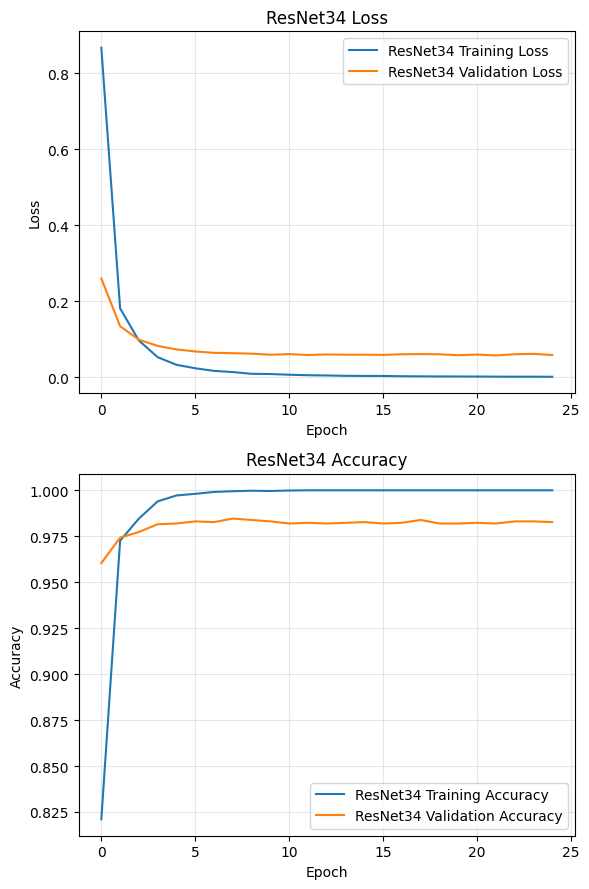

In [17]:
# TODO: 5. Plot the loss and accuracy curves.
# ==== Plot ResNet34 curves ====
plt.figure(figsize=(6, 9))

# -------- Loss subplot --------
plt.subplot(2, 1, 1)
plt.plot(train_losses_resnet34, label="ResNet34 Training Loss")
plt.plot(val_losses_resnet34,   label="ResNet34 Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet34 Loss")
plt.legend()
plt.grid(alpha=0.3)

# -------- Accuracy subplot --------
plt.subplot(2, 1, 2)
plt.plot(train_accs_resnet34, label="ResNet34 Training Accuracy")
plt.plot(val_accs_resnet34,   label="ResNet34 Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet34 Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [63]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [64]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH   = 40           # total epochs
INIT_LR     = 1e-7          # initial learning rate
BATCH_SIZE  = 128            # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 6.0           # distillation temperature
LOSS_RATIO  = 0.7          # weight for KD loss vs CE loss

In [65]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.

import torchvision.models as models
import torch.nn as nn

# build a fresh student network (no pretrained weights)
resnet18 = models.resnet18(weights=None)
in_features = resnet18.fc.in_features  # 512 for ResNet18

# add dropout before the final classifier to mitigate overfitting
resnet18.fc = nn.Sequential(
    nn.Dropout(p=0.3),                 # Drop  % of features
    nn.Linear(in_features, int(num_classes))
)

# move model to GPU / CPU
resnet18 = resnet18.to(device)

# resnet18 = torchvision.models.resnet18(weights=None)
# resnet18.fc = nn.Linear(resnet18.fc.in_features, int(num_classes))
# resnet18 = resnet18.to(device)

In [66]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet34 = torchvision.models.resnet34(weights=None)
resnet34.fc = nn.Linear(resnet34.fc.in_features, int(num_classes))
resnet34.load_state_dict(torch.load("resnet34_checkpoint.pkl", map_location=device, weights_only=False))
resnet34 = resnet34.to(device)
resnet34.eval()
for p in resnet34.parameters():
    p.requires_grad = False     # freeze teacher

In [67]:
# TODO: 4. Define the optimizer, loss function, etc.


optimizer = torch.optim.AdamW(resnet18.parameters(), weight_decay=1e-4)
scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer,
#     T_max=MAX_EPOCH,   # one full cosine cycle across all epochs
#     eta_min=1e-6       # final learning rate
# )
criterion_ce = nn.CrossEntropyLoss()
criterion_kd = nn.KLDivLoss(reduction="batchmean")

# DataLoaders (reuse tensors)
train_ds = torch.utils.data.TensorDataset(tensor_train, labels_train_index)
val_ds   = torch.utils.data.TensorDataset(tensor_val,   labels_val_index)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [68]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.

train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18 = [], [], [], []
best_val_acc = 0.0

for epoch in range(MAX_EPOCH):
    # --------- Train ----------
    resnet18.train()
    running_loss, running_correct = 0.0, 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)

        optimizer.zero_grad()
        outputs_student = resnet18(imgs)
        with torch.no_grad():
            outputs_teacher = resnet34(imgs)

        loss_kd = criterion_kd(
            F.log_softmax(outputs_student / TEMPERATURE, dim=1),
            F.softmax(outputs_teacher / TEMPERATURE, dim=1)
        ) * (TEMPERATURE ** 2)

        loss_ce = criterion_ce(outputs_student, lbls)
        loss = LOSS_RATIO * loss_kd + (1.0 - LOSS_RATIO) * loss_ce

        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * imgs.size(0)
        running_correct += (outputs_student.argmax(1) == lbls).sum().item()

    scheduler.step()

    epoch_loss = running_loss / tensor_train.shape[0]
    epoch_acc  = running_correct / tensor_train.shape[0]
    train_losses_resnet18.append(epoch_loss)
    train_accs_resnet18.append(epoch_acc)

    # --------- Validation ----------
    resnet18.eval()
    val_running_loss, val_running_correct = 0.0, 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            outputs_student = resnet18(imgs)
            outputs_teacher = resnet34(imgs)

            val_loss_kd = criterion_kd(
                F.log_softmax(outputs_student / TEMPERATURE, dim=1),
                F.softmax(outputs_teacher / TEMPERATURE, dim=1)
            ) * (TEMPERATURE ** 2)
            val_loss_ce = criterion_ce(outputs_student, lbls)
            val_loss = LOSS_RATIO * val_loss_kd + (1.0 - LOSS_RATIO) * val_loss_ce

            val_running_loss    += val_loss.item() * imgs.size(0)
            val_running_correct += (outputs_student.argmax(1) == lbls).sum().item()

    val_epoch_loss = val_running_loss / tensor_val.shape[0]
    val_epoch_acc  = val_running_correct / tensor_val.shape[0]
    val_losses_resnet18.append(val_epoch_loss)
    val_accs_resnet18.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{MAX_EPOCH}] "
          f"Train Loss: {epoch_loss:.4f}  Train Acc: {epoch_acc:.4f}  "
          f"Val Loss: {val_epoch_loss:.4f}  Val Acc: {val_epoch_acc:.4f}")

    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(resnet18.state_dict(), "resnet18_checkpoint.pkl")


Epoch [1/40] Train Loss: 3.1725  Train Acc: 0.5194  Val Loss: 3.1520  Val Acc: 0.5062
Epoch [2/40] Train Loss: 2.3855  Train Acc: 0.6551  Val Loss: 2.2653  Val Acc: 0.6585
Epoch [3/40] Train Loss: 2.0661  Train Acc: 0.7105  Val Loss: 2.1282  Val Acc: 0.6815
Epoch [4/40] Train Loss: 1.7917  Train Acc: 0.7524  Val Loss: 1.9551  Val Acc: 0.6908
Epoch [5/40] Train Loss: 1.6128  Train Acc: 0.7865  Val Loss: 2.7598  Val Acc: 0.5473
Epoch [6/40] Train Loss: 1.5081  Train Acc: 0.7967  Val Loss: 1.5145  Val Acc: 0.7588
Epoch [7/40] Train Loss: 1.3797  Train Acc: 0.8156  Val Loss: 1.3682  Val Acc: 0.7900
Epoch [8/40] Train Loss: 1.2390  Train Acc: 0.8354  Val Loss: 1.5843  Val Acc: 0.7492
Epoch [9/40] Train Loss: 1.1211  Train Acc: 0.8528  Val Loss: 1.2934  Val Acc: 0.7950
Epoch [10/40] Train Loss: 1.0480  Train Acc: 0.8678  Val Loss: 1.4786  Val Acc: 0.7723
Epoch [11/40] Train Loss: 0.9625  Train Acc: 0.8804  Val Loss: 1.4268  Val Acc: 0.7719
Epoch [12/40] Train Loss: 0.8488  Train Acc: 0.8987 

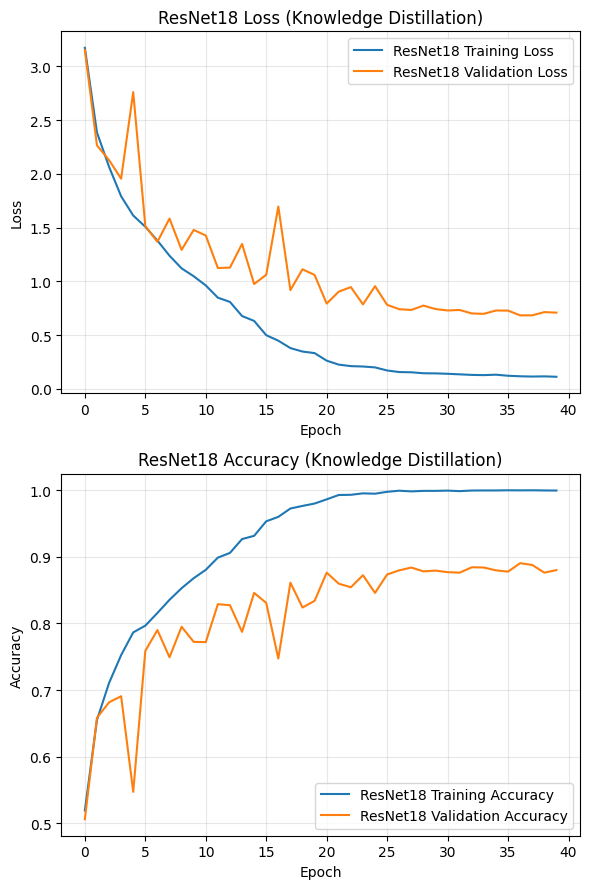

In [69]:
# TODO: 6. Plot the loss and accuracy curves.
# ==== Plot ResNet18 curves ====
plt.figure(figsize=(6, 9))

# -------- Loss subplot --------
plt.subplot(2, 1, 1)
plt.plot(train_losses_resnet18, label="ResNet18 Training Loss")
plt.plot(val_losses_resnet18,   label="ResNet18 Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet18 Loss (Knowledge Distillation)")
plt.legend()
plt.grid(alpha=0.3)

# -------- Accuracy subplot --------
plt.subplot(2, 1, 2)
plt.plot(train_accs_resnet18, label="ResNet18 Training Accuracy")
plt.plot(val_accs_resnet18,   label="ResNet18 Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet18 Accuracy (Knowledge Distillation)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [70]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

# ---------- 1. build the same network as during training ----------
resnet18 = torchvision.models.resnet18(weights=None)
in_feats  = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Dropout(p=0.3),                 # must match training topology
    nn.Linear(in_feats, num_classes)   # keys: fc.1.weight / fc.1.bias
)

# ---------- 2. load weights ----------
state = torch.load(
    "resnet18_checkpoint.pkl",
    map_location=device,
    weights_only=True                 # loads tensors only (safer)
)
resnet18.load_state_dict(state, strict=True)   # keys match exactly

# ---------- 3. move to device & eval mode ----------
resnet18 = resnet18.to(device).eval()

In [71]:
# TODO: 2. Do prediction using the images in the testing set.
predictions = []
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(tensor_test),  # dataset of only images
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

with torch.no_grad():
    for (imgs,) in test_loader:                   # (imgs,) since dataset returns a tuple
        imgs = imgs.to(device)
        outputs = resnet18(imgs)
        preds = outputs.argmax(dim=1).cpu().tolist()
        predictions.extend(preds)

In [72]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

index_to_label = torch.load("D:/Phase-2-Data-Science-FengJiang-main/3. Deep Learning Project/data_preprocessed/index_to_label.pt", weights_only=False)

with open("submission.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["file_name", "label"])
    for idx, pred_idx in enumerate(predictions):
        writer.writerow([f"{idx}.jpg", index_to_label[int(pred_idx)]])